In [2]:
pip install sentinelhub geopandas rasterio shapely

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/24.8 MB ? eta -:--:--
   --- ------------------------------------ 2.4/24.8 MB 10.3 MB/s eta 0:00:03
   -------- ------------------------------- 5.0/24.8 MB 10.8 MB/s eta 0:00:02
   ------------ --------------------------- 7.6/24.8 MB 11.5 MB/s eta 0:00:02
   ---------------- ----------------------- 10.2/24.8 MB 11.6 MB/s eta 0:00:02
   -------------------- ------------------- 12.8/24.8 MB 11.8 MB/s eta 0:00:02
   ------------------------ --------------- 15.5/24.8 MB 11.9 MB/s eta 0:00:01
   ----------------------------- ---------- 18.4/24.8 MB 11.9 MB/s eta 0:00:01
   --------------------------------- ------ 20.4/24.8 MB 11.7 MB/s eta 0:00:01
   ------------------------------------- -- 23.3/24.8 MB 11.8 MB/s eta 0:00:01
   ---------------------------------------  24.6/24.8 MB 11.9 MB/s eta 0:00:01
   --------------------------------------

In [3]:

import geopandas as gpd
from sentinelhub import SHConfig, BBox, CRS, DataCollection, MimeType, SentinelHubRequest, bbox_to_dimensions
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon


config = SHConfig()
config.sh_client_id = '68851904-71b3-4437-a070-3769584db072'
config.sh_client_secret = 'lBrdLCTRyKpRjKR25Gb4m4r6pKYAyyjN'


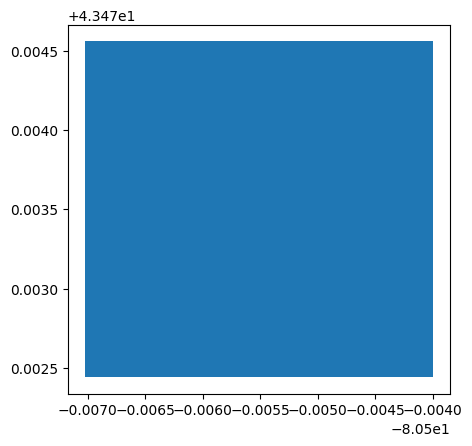

In [5]:
#Adding the field to the system for the first time.

# A polygon that defines the boundary of the field somewhere in Canada
coordinates = [
    [-80.50702, 43.47244],  # Point 1
    [-80.50702, 43.47456],  # Point 2
    [-80.50400, 43.47456],  # Point 3
    [-80.50400, 43.47244],  # Point 4
    [-80.50702, 43.47244]   # Point 1 again to close the polygon
]

field_polygon = Polygon(coordinates)
geo_df = gpd.GeoDataFrame({'geometry': [field_polygon]}, crs='EPSG:4326')

# Plotting the field area
geo_df.plot()
plt.show()

# Defining a bounding box (BBox) for the field
bbox = BBox(bbox=field_polygon.bounds, crs=CRS.WGS84)
bbox_size = bbox_to_dimensions(bbox, resolution=10)


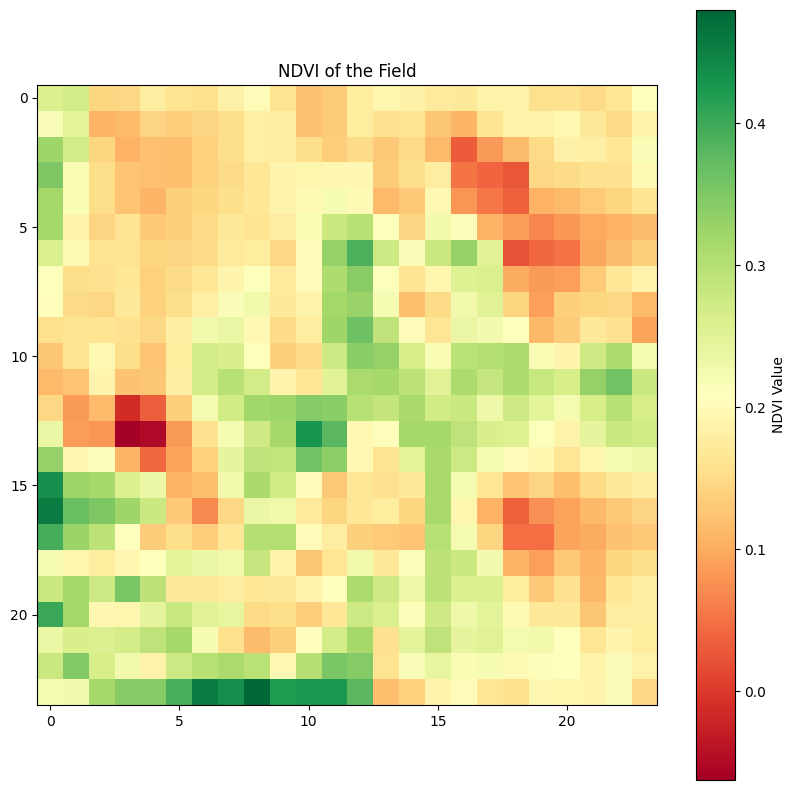

In [6]:

# Defining a SentinelHubRequest for NDVI
ndvi_request = SentinelHubRequest(
    evalscript="""
        //VERSION=3
        function setup() {
            return {
                input: ["B04", "B08"],
                output: { bands: 1, sampleType: "FLOAT32" }
            };
        }

        function evaluatePixel(sample) {
            let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
            return [ndvi];
        }
    """,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=('2023-07-01', '2023-07-31'),
            mosaicking_order='mostRecent'
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF)
    ],
    bbox=bbox,
    size=bbox_size,
    config=config
)

# Fetching NDVI data
ndvi_data = ndvi_request.get_data()[0]

# Plotting the NDVI data
plt.figure(figsize=(10, 10))
plt.imshow(ndvi_data, cmap='RdYlGn')
plt.colorbar(label='NDVI Value')
plt.title('NDVI of the Field')
plt.show()

In [7]:

# Extracting average NDVI value for the field
avg_ndvi = np.nanmean(ndvi_data)
print(f'Average NDVI for the field: {avg_ndvi:.3f}')

Average NDVI for the field: 0.201
